# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
I plan on analyzing the movie corpus. My broad plan is to merge the movie script corpus with information on IMDb scores and reviews as well as box-office revenue information. IMDb information from IMDb's data website - "contains the IMDb rating and votes information for titles". Might also use this 5000 movie dataset that has more information beyond just scores and revenue. This is in order to predict what would be an ideal/ lucrative script - i.e. what genre of scripts, kind of characters, gender relationships, length, common themes, common titles, potentially actors and directors and trends between different decades. The primary analysis will be based on the scripts and use frequency as well as context of word usage in the script.  I hopr to use topic modeling to identify features of the scripts and once I figure out several important themes and topics (might overlap with genres perhaps), I will collect the scripts that relate to these topics. Then, I will try to see if any general overlapping sentiment score can be calculated for the scripts.

## ***Why?***
I think this would be an interesting data analysis project as far as entertainment and movie analysis is concerned. I am taking a class on the economics of cultural policy and ran the idea by my professor and he suggested that it would be helpful since there isn't much broad script analysis done. The results would be helpful to movie conglomerates to know more definitely what kind of script themes and movies tend to do better at the box office. I would anticipate it is the more mass-produced marvel films in recent times for example but the data might help put this in the context of all different types of movies.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

I am seeking to make inferences about the movie industry as well as preferences of the public as far as type of scripts are concerned. Comparing the male and female characters in the most lucrative films will inform us about the general disparity in the kinds of movies that tend to see box office success. My primary concern/ the potential limitations are parsing through the context of the texts, and unlike the soap opera corpus, the movie corpus does not have indicators for which character is speaking. Also, the count by years is different so sampling based on years might not be the best option. I might to need to resort to either convenience or relevance sampling depending on the inflation adjusted box office revenue that is available or based on the script count focus my analysis on a particular genre. From the IMDb dataset, I was able to find score and revenue information for 5000 films but need to check the overlap with the scripts I have available. A reasonable path to scale up would be to also include the TV corpus information to check overlap between movie and TV information which might add some interesting nuances. Also, the movie corpus is limtied to just Hollywood films which are largely English speaking so any analysis will shed light only on Western movie ideals and concepts in the broadest sense. Potentially adding other film industries like Bollywood or Nollywood would be a good way to scale up the analysis.

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [2]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [100]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [4]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [5]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [6]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [7]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


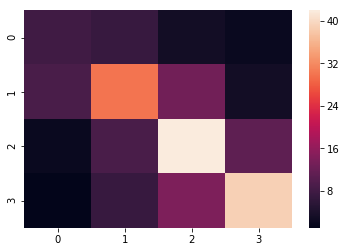

In [8]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [9]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [10]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [11]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [12]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [13]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


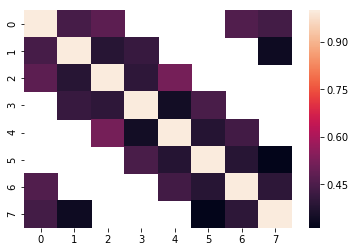

In [14]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [15]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [16]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [17]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

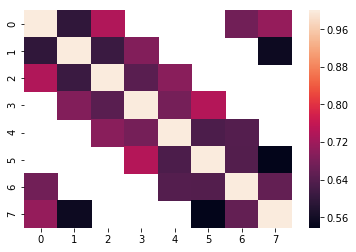

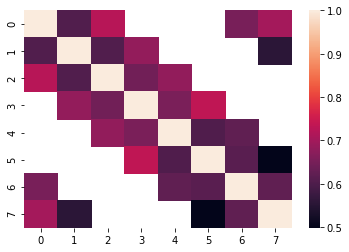

In [18]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [19]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

Asked friends to rank 10 actors from 1 to 10 based on how attractive they found the actor in question. - https://docs.google.com/forms/d/e/1FAIpQLSfNGTM1jWN4zNiU_hmQLi03ESPZWC02V_w6kA1jivZZO2Fdtw/viewform

In [131]:
x = np.loadtxt(r"C:\Users\iarak\OneDrive\Desktop\CCA\celebs.txt")
anno = AnnotationsContainer.from_array(x)

In [132]:
x

array([[ 6.,  7.,  8.,  9.,  7.,  7.,  8.,  8.,  4.,  5.,  2.],
       [ 1.,  1.,  6.,  8.,  8., 10.,  3.,  6.,  7.,  6., 10.],
       [ 7.,  9.,  4.,  1.,  9., 10.,  6.,  5.,  4.,  4.,  3.],
       [ 7.,  7.,  5.,  7.,  8.,  7.,  6.,  8.,  7.,  7.,  8.],
       [ 5.,  5.,  6.,  6.,  4.,  7.,  8.,  6.,  5.,  4.,  3.],
       [10.,  5.,  7.,  9.,  9.,  3.,  7.,  7., 10.,  7.,  9.],
       [ 7.,  7.,  7.,  6.,  8.,  3.,  7.,  5.,  3.,  6.,  6.],
       [ 5.,  9.,  9.,  9.,  7., 10.,  5.,  8.,  7.,  4.,  9.],
       [ 7.,  8.,  6.,  5.,  7.,  4.,  8.,  8.,  6.,  6.,  7.],
       [10., 10., 10., 10., 10., 10.,  7.,  9.,  9.,  9.,  9.]])

In [133]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.02727273, 0.00909091, 0.05454545, 0.07272727, 0.1       ,
       0.13636364, 0.23636364, 0.12727273, 0.12727273, 0.10909091])

[[ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  8.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 11.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 26.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 14.]]


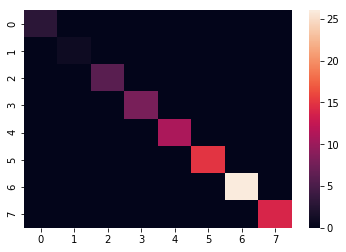

In [134]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:], anno.annotations[:],8)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [137]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.3670886075949367

In [115]:
fleiss_kappa(anno.annotations[::])

0.07460960092539037

In [116]:
krippendorffs_alpha(anno.annotations[::])

0.15370671893854349

In [117]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.38271604938271603

In [118]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.38271605  0.05882353  0.1011236   0.06976744  0.
   0.04761905 -0.01123596]
 [ 0.38271605  1.          0.20454545  0.18604651  0.15662651  0.1954023
   0.06976744  0.20454545]
 [ 0.05882353  0.20454545  1.          0.18604651 -0.03448276 -0.01123596
   0.16666667  0.14634146]
 [ 0.1011236   0.18604651  0.18604651  1.          0.1954023   0.13978495
  -0.12359551  0.4047619 ]
 [ 0.06976744  0.15662651 -0.03448276  0.1954023   1.          0.06976744
  -0.2195122   0.03614458]
 [ 0.          0.1954023  -0.01123596  0.13978495  0.06976744  1.
  -0.12359551  0.13978495]
 [ 0.04761905  0.06976744  0.16666667 -0.12359551 -0.2195122  -0.12359551
   1.         -0.2195122 ]
 [-0.01123596  0.20454545  0.14634146  0.4047619   0.03614458  0.13978495
  -0.2195122   1.        ]]


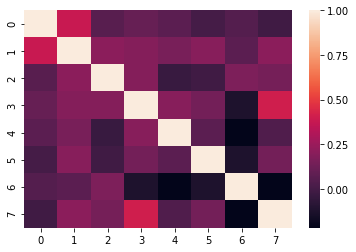

In [119]:
ax = seaborn.heatmap(m)
plt.show()

There seems to be some agreements between the coders, although not much (as reflected by the many darker shades of purple and black in the heatmatp).

In [138]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.059612975646359354

In [139]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5149253731343284

In [140]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.15137446302656213

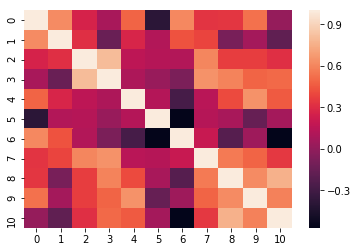

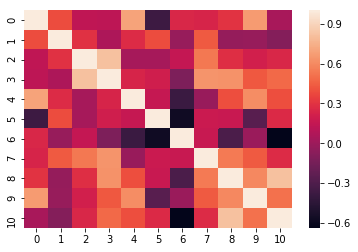

In [141]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

As we can see above, there seems to be a lot more agreements detected with this correlation method, as denoted by the lighter shades in these heatmaps. However, there still seems to be some disagreement denoted by black boxes in the heatmaps, which shows little correlation between coders.

In [124]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.16158824653177684 0.15365092873759786


# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

There are a few coders who overlap however given there are so many answer options which is why the metric calculations might be showing small coefficients. I'm not really sure how to interpret this model a and b stuff.

In [207]:
# create a new instance of model A, with 10 label classes
model = ModelB.create_initial_state(10, 11)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[6.35858255e-01 1.54654748e-01 3.57962591e-02 ... 1.66188662e-02
   2.56057825e-03 3.42613463e-02]
  [1.08621392e-01 4.33516051e-01 1.78771008e-01 ... 3.41205137e-02
   3.30063131e-02 3.18275451e-02]
  [2.21541494e-02 1.55241579e-01 5.96499546e-01 ... 4.59656412e-03
   1.79134777e-02 1.68713073e-02]
  ...
  [7.77839591e-02 7.11236800e-02 4.93792693e-02 ... 3.42974100e-01
   1.28894580e-01 9.66676476e-02]
  [1.17468661e-02 3.13307976e-02 5.49232941e-02 ... 2.09459251e-01
   4.53901494e-01 1.16211449e-01]
  [1.09538777e-02 1.99028195e-02 2.60594151e-02 ... 7.24067902e-02
   1.89306787e-01 5.25843155e-01]]

 [[4.88881887e-01 1.04017872e-01 1.04512287e-01 ... 4.89313844e-02
   1.21482483e-03 9.35569930e-02]
  [2.38468639e-01 4.99336528e-01 9.15793527e-02 ... 1.18628475e-02
   1.15316539e-02 5.84007541e-02]
  [7.48643100e-02 1.97252411e-02 5.55762216e-01 ... 7.38451124e-03
   7.42664806e-02 4.97206620e-03]
  ...
  [4.24794098e-02 8.86226152e-03 2.54461042e-02 ... 4.81815874e-01
   6.99834

In [208]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 9, burn_in_samples=5, thin_samples=1)

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [209]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.78947368 0.15789474 0.05263158 ... 0.         0.         0.        ]
  [0.13636364 0.68181818 0.13636364 ... 0.         0.         0.        ]
  [0.04347826 0.13043478 0.65217391 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.65217391 0.13043478 0.04347826]
  [0.         0.         0.         ... 0.13041967 0.65209833 0.13053556]
  [0.         0.         0.         ... 0.05000667 0.15002    0.79997334]]

 [[0.78947368 0.15789474 0.05263158 ... 0.         0.         0.        ]
  [0.13636364 0.68181818 0.13636364 ... 0.         0.         0.        ]
  [0.04347826 0.13043478 0.65217391 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.65217391 0.13043478 0.04347826]
  [0.         0.         0.         ... 0.13041967 0.69557156 0.13053556]
  [0.         0.         0.         ... 0.05000667 0.15002    0.79997334]]

 [[0.78947368 0.15789474 0.05263158 ... 0.         0.         0.        ]
  [0.13636364 0.681818

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


In [211]:
model = ModelB.create_initial_state(10, 11)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.78947368 0.15789474 0.05263158 ... 0.         0.         0.        ]
  [0.13636364 0.68181818 0.13636364 ... 0.         0.         0.        ]
  [0.04347826 0.13043478 0.65217391 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.65217391 0.13043478 0.04347826]
  [0.         0.         0.         ... 0.13041967 0.65209833 0.13053556]
  [0.         0.         0.         ... 0.05000667 0.15002    0.79997334]]

 [[0.78947368 0.15789474 0.05263158 ... 0.         0.         0.        ]
  [0.13636364 0.68181818 0.13636364 ... 0.         0.         0.        ]
  [0.04347826 0.13043478 0.65217391 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.65217391 0.13043478 0.04347826]
  [0.         0.         0.         ... 0.13041967 0.69557156 0.13053556]
  [0.         0.         0.         ... 0.05000667 0.15002    0.79997334]]

 [[0.78947368 0.15789474 0.05263158 ... 0.         0.         0.        ]
  [0.13636364 0.681818

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [212]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 7.15871284e-006 9.99992841e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000

Let's turn the posterior of the first 100 samples into a heatmap.

In [216]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

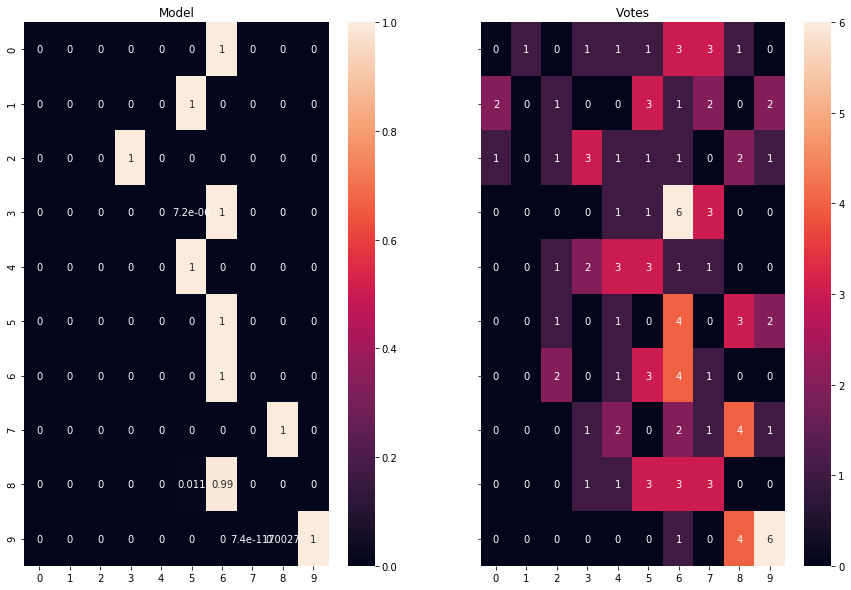

In [217]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

Coder 9 and 6 are the most similar based on the heatmaps?

In [218]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [219]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.55352448 0.12996648 0.07424829 ... 0.03830823 0.03257448 0.03132306]
  [0.12397271 0.50287619 0.12119369 ... 0.02831876 0.02993366 0.02865904]
  [0.06092831 0.1207549  0.4846363  ... 0.02810525 0.03292366 0.03337895]
  ...
  [0.03891118 0.02721766 0.03082491 ... 0.47816139 0.11253465 0.05937288]
  [0.02679811 0.03075909 0.02873406 ... 0.11915327 0.47842043 0.13687411]
  [0.03735322 0.03179364 0.03281915 ... 0.06708572 0.13401212 0.56106421]]

 [[0.54434277 0.13917038 0.06410588 ... 0.03408338 0.03735568 0.03505303]
  [0.12216145 0.51540877 0.1200413  ... 0.02871985 0.03183903 0.0317995 ]
  [0.05850072 0.12729009 0.47515227 ... 0.0336051  0.02980075 0.03203574]
  ...
  [0.03676361 0.02984718 0.02737848 ... 0.48174183 0.12510047 0.06358878]
  [0.02822928 0.02991766 0.0341984  ... 0.12154232 0.50753622 0.12166998]
  [0.0360728  0.03192759 0.03041049 ... 0.0666743  0.12856234 0.57030228]]

 [[0.55277958 0.14273922 0.06785193 ... 0.03278254 0.03865755 0.03458709]
  [0.12261185 0.500209

Let's try everything again with ModelBt

In [221]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(10, 11)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.72741553 0.86265828 0.90193891 0.9487257  0.62684583 0.92014565
 0.68384584 0.86313245 0.83121957 0.90900539 0.85259962]
-321.6550269729477


In [222]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.3332896  0.48076121 0.90322369 0.47812273 0.16759615 0.35986934
 0.38100499 0.48411704 0.3902501  0.57783862 0.19191828]
-236.35907293182305


In [223]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[2.03919757e-04 1.27615365e-04 3.10554748e-07 7.74641393e-04
  4.97240138e-10 2.09067878e-03 3.34105645e-02 9.60077457e-01
  3.08675397e-03 2.28058257e-04]
 [1.87478515e-03 1.46406298e-05 4.21875746e-07 3.29782236e-05
  9.89819419e-12 9.95867775e-01 6.17706196e-04 8.95068167e-04
  9.18013053e-05 6.04823224e-04]
 [2.06332421e-03 7.32645785e-05 8.14584970e-07 9.83636670e-01
  4.18342467e-10 3.15893694e-03 2.41440148e-03 2.99781218e-04
  6.93682005e-03 1.41598675e-03]
 [4.20048617e-06 1.22981464e-06 6.39703060e-09 2.77017468e-06
  6.98400687e-11 5.30257180e-05 9.99761744e-01 1.64614371e-04
  7.71132049e-06 4.69770839e-06]
 [7.48150224e-05 2.19042762e-05 2.43540529e-07 1.10138572e-03
  3.19809057e-09 9.97272348e-01 8.11775690e-04 4.96506912e-04
  1.37346629e-04 8.36710667e-05]
 [9.62310842e-06 2.81744519e-06 7.41503120e-08 6.34633472e-06
  1.58729078e-11 2.19288749e-05 9.99104571e-01 1.15283152e-05
  5.64201356e-04 2.78909116e-04]
 [2.63753150e-05 7.72214144e-06 1.17065536e-06 1.73942317e

Let's visualize the posterior of the first 10 samples according to ModelBt.

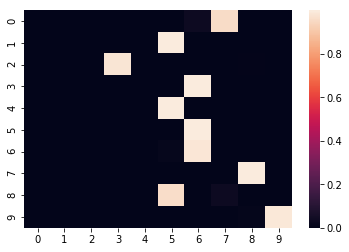

In [224]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [225]:
model = ModelBt.create_initial_state(10, 3, theta=[0.33,0.48,0.90])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.33, 0.48, and 0.90 respectively for the first three from model.theta.
model.generate_annotations(20)

array([[3, 3, 0],
       [2, 2, 3],
       [3, 3, 0],
       [0, 0, 0],
       [1, 2, 0],
       [2, 3, 0],
       [1, 1, 0],
       [0, 2, 3],
       [3, 0, 3],
       [1, 1, 1],
       [3, 1, 0],
       [3, 2, 3],
       [1, 1, 1],
       [3, 3, 1],
       [3, 1, 2],
       [0, 1, 3],
       [1, 3, 0],
       [0, 0, 1],
       [3, 3, 0],
       [1, 1, 3]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [226]:
model = ModelBt.create_initial_state(10, 11)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

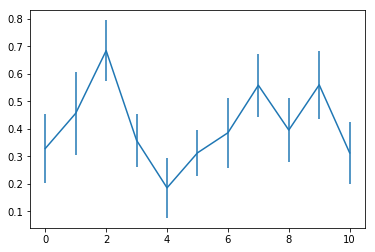

In [229]:
plt.figure()
plt.errorbar(range(11),y, yerr = y_ci)
plt.show()

# Q3

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

There is not much info on how to interpret the information given for model A and B

In [175]:
x = np.loadtxt(r"C:\Users\iarak\OneDrive\Desktop\CCA\celebs.txt")
anno = AnnotationsContainer.from_array(x)

Let's examine the data structure.

In [176]:
x.shape

(10, 11)

In [70]:
anno_dv.labels

[0, 1]

In [177]:
anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [71]:
anno_dv.missing_values

[-1]

In [72]:
anno_dv.annotations.shape

(21461, 6)

In [178]:
anno.annotations.shape

(10, 11)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [73]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[1.         0.62426874 0.46682841 0.44599604 0.16569888 0.36657805]
 [0.62426874 1.         0.53480937 0.52673854 0.3306905  0.59513211]
 [0.46682841 0.53480937 1.         0.50580068 0.42393752 0.49833997]
 [0.44599604 0.52673854 0.50580068 1.         0.46517493 0.47023754]
 [0.16569888 0.3306905  0.42393752 0.46517493 1.         0.66190749]
 [0.36657805 0.59513211 0.49833997 0.47023754 0.66190749 1.        ]]


In [179]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.38271605  0.05882353  0.1011236   0.06976744  0.
   0.04761905 -0.11111111  0.15662651 -0.03448276  0.03225806]
 [ 0.38271605  1.          0.20454545  0.18604651  0.15662651  0.1954023
   0.06976744 -0.03448276  0.06976744  0.         -0.01123596]
 [ 0.05882353  0.20454545  1.          0.18604651 -0.03448276 -0.01123596
   0.16666667  0.29411765  0.06976744  0.26829268  0.        ]
 [ 0.1011236   0.18604651  0.18604651  1.          0.1954023   0.13978495
  -0.12359551 -0.04651163  0.          0.09090909  0.18604651]
 [ 0.06976744  0.15662651 -0.03448276  0.1954023   1.          0.06976744
  -0.2195122  -0.08433735 -0.04651163 -0.01123596  0.1954023 ]
 [ 0.          0.1954023  -0.01123596  0.13978495  0.06976744  1.
  -0.12359551 -0.03092784  0.03614458  0.01098901 -0.01123596]
 [ 0.04761905  0.06976744  0.16666667 -0.12359551 -0.2195122  -0.12359551
   1.          0.11392405 -0.14942529 -0.03448276 -0.11111111]
 [-0.11111111 -0.03448276  0.29411765 -0.04651163 -0.08433

Let's visualize that...

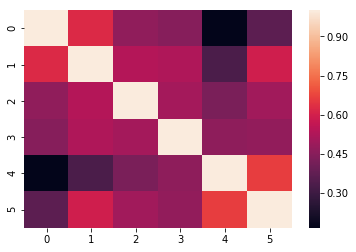

In [74]:
ax = seaborn.heatmap(m)
plt.show()

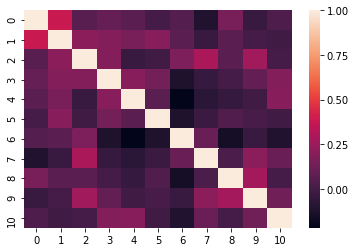

In [180]:
ax = seaborn.heatmap(m)
plt.show()

In [75]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

In [181]:
pairwise_metric_average(cohens_kappa, anno.annotations)

0.059612975646359354

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [183]:
ck = pairwise_matrix(cohens_kappa, anno.annotations)
pr = pairwise_matrix(pearsons_rho, anno.annotations)
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

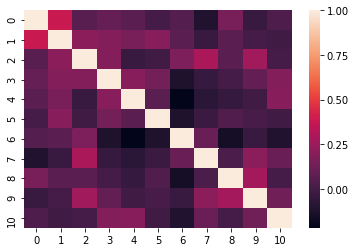

In [187]:
seaborn.heatmap(ck)

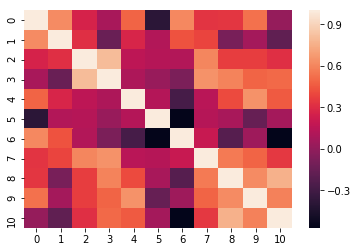

In [189]:
seaborn.heatmap(pr)

Now we will compare the student coders.

In [252]:
nondiag = (np.eye(11)-np.ones(1))*-1.0

In [253]:
xck = pairwise_matrix(cohens_kappa, anno.annotations)
xpr = pairwise_matrix(pearsons_rho, anno.annotations)

print(np.average(xck, weights=nondiag))
print(np.average(xpr, weights=nondiag))

0.05961297564635937
0.2381744038167413


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [233]:
anno_merge = AnnotationsContainer.from_array(mergedata[:,0:10])


In [234]:
print(cohens_kappa(anno_merge.annotations[:,0], anno_merge.annotations[:,1]))
print(pearsons_rho(anno_merge.annotations[:,0], anno_merge.annotations[:,1]))

0.3744311057948666
0.38563437203620626


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [235]:

print(np.average(anno_merge.annotations[:,0]))
print(np.average(anno_merge.annotations[:,1]))


0.4763912310286678
0.35834738617200673


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [241]:
x.shape

(10, 11)

In [255]:
negs2 = np.ones((10, 2), dtype=np.int)*(-1)
xA = np.concatenate((x, negs2), axis=1)
xA

array([[ 6.,  7.,  8.,  9.,  7.,  7.,  8.,  8.,  4.,  5.,  2., -1., -1.],
       [ 1.,  1.,  6.,  8.,  8., 10.,  3.,  6.,  7.,  6., 10., -1., -1.],
       [ 7.,  9.,  4.,  1.,  9., 10.,  6.,  5.,  4.,  4.,  3., -1., -1.],
       [ 7.,  7.,  5.,  7.,  8.,  7.,  6.,  8.,  7.,  7.,  8., -1., -1.],
       [ 5.,  5.,  6.,  6.,  4.,  7.,  8.,  6.,  5.,  4.,  3., -1., -1.],
       [10.,  5.,  7.,  9.,  9.,  3.,  7.,  7., 10.,  7.,  9., -1., -1.],
       [ 7.,  7.,  7.,  6.,  8.,  3.,  7.,  5.,  3.,  6.,  6., -1., -1.],
       [ 5.,  9.,  9.,  9.,  7., 10.,  5.,  8.,  7.,  4.,  9., -1., -1.],
       [ 7.,  8.,  6.,  5.,  7.,  4.,  8.,  8.,  6.,  6.,  7., -1., -1.],
       [10., 10., 10., 10., 10., 10.,  7.,  9.,  9.,  9.,  9., -1., -1.]])

In [243]:
anno_xA = AnnotationsContainer.from_array(xA)
model_xA = ModelA.create_initial_state(2)
model_xA.theta

array([0.76226519, 0.61874535, 0.73608479, 0.81498378, 0.9010209 ,
       0.89346279, 0.81168871, 0.63629279])

In [283]:
model_xB = ModelB.create_initial_state(10, 11)
print(model_xB.pi)
print(model_xB.log_likelihood(anno.annotations))

[0.01091329 0.02669829 0.03700753 0.41227966 0.00898391 0.01508785
 0.07779565 0.09782932 0.30161185 0.01179265]
-261.2267374675295


In [273]:
model_xB.map(anno.annotations)
print(model_xB.pi)
print(model_xB.log_likelihood(anno.annotations))

[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e-001
 0.00000000e+000 2.01052303e-001 4.98947697e-001 6.06327483e-110
 1.00266575e-001 9.97334251e-002]
-200.89809495383435


C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


In [271]:
# compute the posterior distribution over true annotations
posterior_xB = model_xB.infer_labels(anno.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior_xB)

[[3.96438213e-12 2.03180089e-06 1.17070997e-06 1.80599438e-05
  3.69454522e-06 2.74884046e-02 9.45222776e-01 2.72141026e-02
  8.21065178e-06 4.15487888e-05]
 [1.14624920e-08 2.10415703e-02 2.11826481e-06 1.12567360e-07
  1.13909113e-03 5.71821281e-01 9.46916201e-02 4.04804367e-02
  2.72983184e-04 2.70550776e-01]
 [3.21738255e-09 5.89386203e-03 1.01130434e-03 2.59874573e-02
  9.51790623e-01 1.01934402e-02 7.11399177e-04 1.06228579e-04
  4.79002570e-05 4.25778187e-03]
 [7.60253559e-13 2.11832754e-12 1.11023880e-14 7.31006749e-15
  7.31471371e-11 4.64605968e-04 9.99518221e-01 1.71541804e-05
  1.83180587e-08 1.40040318e-12]
 [1.38735752e-12 3.24004888e-08 2.23726178e-07 2.72721388e-03
  7.92846758e-03 9.89188449e-01 1.44222967e-04 1.13786114e-05
  1.13290209e-08 1.91724861e-10]
 [1.07946545e-06 1.59714708e-03 1.08568424e-06 8.69922191e-03
  6.39401572e-02 4.92580399e-02 1.41924844e-01 2.82322314e-02
  7.04901207e-01 1.44498659e-03]
 [4.09823200e-09 5.08034971e-09 9.60801377e-08 4.43614015e

In [274]:
samples_xB = model_xB.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [275]:
# we can then compute a credible interval for the parameters:
ci_x_mean = samples_xB[0].mean(axis=0)
print("Mean")
print(ci_x_mean)

ci_x_stdev = samples_xB[0].std(axis=0)
print("\nSTD")
print(ci_x_stdev)


Mean
[[[0.54673827 0.13177836 0.07803859 ... 0.03140113 0.03684149 0.03586908]
  [0.11354454 0.50515402 0.13606011 ... 0.03311326 0.02899403 0.02845327]
  [0.06182521 0.12095105 0.4831965  ... 0.03164363 0.03182481 0.02871945]
  ...
  [0.03306051 0.02945099 0.02898885 ... 0.48109496 0.1234107  0.0590375 ]
  [0.02832877 0.02698453 0.03161122 ... 0.11800837 0.48426157 0.12751817]
  [0.03231929 0.03216494 0.03371206 ... 0.06651388 0.1350079  0.56755451]]

 [[0.55918266 0.13222031 0.07305609 ... 0.03172285 0.03724485 0.02939445]
  [0.12267187 0.49353023 0.12517018 ... 0.02910632 0.03315395 0.0338514 ]
  [0.06157715 0.11979526 0.47895203 ... 0.02751766 0.03450534 0.03219743]
  ...
  [0.03440206 0.02814637 0.03307396 ... 0.47715859 0.12437576 0.06164221]
  [0.03032255 0.03702541 0.0288767  ... 0.11927777 0.50626358 0.12195539]
  [0.03645084 0.03398544 0.033717   ... 0.06509348 0.1306963  0.56783526]]

 [[0.55386334 0.13253189 0.06530733 ... 0.04198445 0.03335878 0.03436644]
  [0.12016585 0.5

We will use Model B estimates for other variable assessments.

In [277]:
#test
model_testB = ModelB.create_initial_state(11, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-264.5798506930321
[7.74429670e-19 1.00000000e+00 4.32097061e-37 3.23649689e-62
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
-61.491277330881175
(48, 6)
(48, 11)


C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


[[[0.55216511 0.12946603 0.06516045 0.03191272 0.0323267  0.03616263
   0.03072956 0.0325386  0.03194706 0.02576584 0.03182529]
  [0.08840536 0.62217279 0.08764988 0.04604857 0.02445813 0.01964373
   0.02139108 0.02263023 0.02243993 0.02285584 0.02230445]
  [0.06339958 0.11898795 0.46462091 0.11518509 0.05865854 0.03199988
   0.02997406 0.02784006 0.03092177 0.03253905 0.02587312]
  [0.02823532 0.05677665 0.12471218 0.46812481 0.11296091 0.06003233
   0.03004259 0.0310025  0.02704022 0.03382381 0.02724868]
  [0.02940544 0.02946284 0.0599073  0.12430635 0.46176518 0.11860276
   0.057676   0.02982587 0.02920342 0.03150289 0.02834196]
  [0.03112813 0.02796694 0.03067735 0.05737878 0.12248046 0.47097029
   0.11971993 0.0554375  0.02832706 0.02738254 0.02853102]
  [0.02732496 0.02635121 0.02669508 0.02726697 0.05995467 0.11191782
   0.49067447 0.11770685 0.05968976 0.02481178 0.02760643]
  [0.03095866 0.02842105 0.03015927 0.0294826  0.02600184 0.06008784
   0.12604873 0.46384792 0.11673708

In [279]:
#indepedent variables
model_ivB = ModelB.create_initial_state(11, 6)
print(model_xB.log_likelihood(anno.annotations))
model_xB.map(anno.annotations)
print(model_xB.pi)
print(model_xB.log_likelihood(anno.annotations))
print(anno.annotations.shape)
posterior_xB = model_xB.infer_labels(anno.annotations)
print(posterior_xB.shape)
samples_xB = model_xB.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_x_mean = samples_xB[0].mean(axis=0)
print(ci_x_mean)



-200.89809495383435
[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e-001
 0.00000000e+000 2.01052303e-001 4.98947697e-001 6.06327483e-110
 1.00266575e-001 9.97334251e-002]
-200.89809495383435
(10, 11)
(10, 10)


C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\pyanno\util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


[[[0.55261874 0.13949821 0.06800027 ... 0.02764325 0.03392185 0.03593482]
  [0.12156004 0.49442589 0.13155143 ... 0.03201779 0.03074036 0.02783385]
  [0.05841114 0.1230695  0.48180649 ... 0.03086017 0.03344941 0.02789801]
  ...
  [0.04037828 0.02938079 0.03164314 ... 0.47446434 0.12536287 0.05805596]
  [0.03211956 0.02684704 0.02475596 ... 0.12606432 0.48833112 0.12896972]
  [0.03302797 0.03535415 0.03071222 ... 0.07188341 0.13857664 0.55108141]]

 [[0.54378898 0.13704548 0.07494291 ... 0.03368811 0.0356754  0.03497396]
  [0.12414356 0.4998205  0.12021937 ... 0.03462653 0.03007781 0.03261738]
  [0.06403943 0.12026807 0.48491904 ... 0.02969681 0.02928538 0.02948712]
  ...
  [0.03434659 0.02651734 0.03247454 ... 0.48152905 0.1195533  0.06381261]
  [0.03040425 0.03318733 0.03366979 ... 0.11680744 0.50376303 0.11641406]
  [0.03766748 0.0378108  0.03140176 ... 0.06227162 0.13020958 0.56908425]]

 [[0.54910986 0.14096079 0.07186796 ... 0.03161774 0.033573   0.03475894]
  [0.12569031 0.496451

Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [280]:
print(posterior_xB.shape)

(10, 10)


In [281]:
predicted_annotations =posterior_xB

In [282]:
predicted_annotations.shape

(10, 10)